<a href="https://colab.research.google.com/github/AmanDesai-coder/CBCA_Ndosho_Electricity_Analysis/blob/main/AmanElectricityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: All work is based off of the kwh dataset initially created by Allison Wong.

First let's import the libraries we will need.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import traces

Next, let's grab the dataframe from the GitHub link. If running locally, you may also use the local file path, but using the GitHub link allows you to run just this notebook without cloning the entire repo.

Some data values have a missing hour component, so we put in noon as a default.

In [3]:
electr_df = pd.read_csv("https://raw.githubusercontent.com/AmanDesai-coder/CBCA_Ndosho_Electricity_Analysis/main/kwh-virunga.csv")
electr_df['Heure'] = electr_df['Heure'].fillna("12:00") 
electr_df.head()

,Jour,Date,Heure,KwH Restant,Achat KwH
0,Mercredi,03-06-2020,18:30,500.0,0.0
1,Mercredi,03-06-2020,18:50,470.0,0.0
2,Jeudi,04-06-2020,8:00,420.0,0.0
3,Jeudi,04-06-2020,17:00,365.0,0.0
4,Vendredi,05-06-2020,8:00,310.0,0.0


In [4]:
electr_df["timestamp"] = electr_df["Date"] + [" "] + electr_df["Heure"]
electr_df["timestamp"] = pd.to_datetime(electr_df["timestamp"],format='%d-%m-%Y %H:%M')
electr_df = electr_df.drop(['Jour', 'Heure', 'Date'], axis = 1)
electr_df.head()

,KwH Restant,Achat KwH,timestamp
0,500.0,0.0,2020-06-03 18:30:00
1,470.0,0.0,2020-06-03 18:50:00
2,420.0,0.0,2020-06-04 08:00:00
3,365.0,0.0,2020-06-04 17:00:00
4,310.0,0.0,2020-06-05 08:00:00


The original column names are in French. We can use the pandas rename method to map these to English translations. Then, we sort the rows by timestamp so that the most recent data is at the end of the dataframe.

In [5]:
electr_df = electr_df.rename(columns = {'KwH Restant' : 'kwH Remaining', 'Achat KwH' : 'kwH Purchased'})
electr_df = electr_df.sort_values('timestamp').reset_index()
electr_df

,index,kwH Remaining,kwH Purchased,timestamp
0,0,500.00,0.0,2020-06-03 18:30:00
1,1,470.00,0.0,2020-06-03 18:50:00
2,2,420.00,0.0,2020-06-04 08:00:00
3,3,365.00,0.0,2020-06-04 17:00:00
4,4,310.00,0.0,2020-06-05 08:00:00
...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00
1489,1489,93.58,0.0,2023-02-06 17:35:00
1490,1490,801.06,800.0,2023-02-07 14:50:00
1491,1491,766.15,0.0,2023-02-07 17:20:00


For each row, we calculate the total amount of electricity purchased at or before the corresponding timestamp. We then subtract the remaining kwH from that value for each row to get the total amount of electricity consumed at or before the corresponding timestamp.

In [6]:
electr_df['Total kwH Purchased'] = np.cumsum(electr_df['kwH Purchased'].values)
electr_df['Total kwH Consumed'] = electr_df['Total kwH Purchased'] - electr_df['kwH Remaining']
electr_df

,index,kwH Remaining,kwH Purchased,timestamp,Total kwH Purchased,Total kwH Consumed
0,0,500.00,0.0,2020-06-03 18:30:00,0.00,-500.00
1,1,470.00,0.0,2020-06-03 18:50:00,0.00,-470.00
2,2,420.00,0.0,2020-06-04 08:00:00,0.00,-420.00
3,3,365.00,0.0,2020-06-04 17:00:00,0.00,-365.00
4,4,310.00,0.0,2020-06-05 08:00:00,0.00,-310.00
...,...,...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00,145355.23,145066.42
1489,1489,93.58,0.0,2023-02-06 17:35:00,145355.23,145261.65
1490,1490,801.06,800.0,2023-02-07 14:50:00,146155.23,145354.17
1491,1491,766.15,0.0,2023-02-07 17:20:00,146155.23,145389.08


Note that the first few values of the "Total kwH Consumed" column are negative. This is because the energy purchased before the survey began is not accounted for, even though it is that energy being used for the first few days. We adjust for this by adding the first value of the "kwH Remaining" column to the "Total kwH Consumed" column.

In [7]:
electr_df['Total kwH Consumed'] = electr_df['kwH Remaining'].iloc[0] + electr_df['Total kwH Consumed']
electr_df

,index,kwH Remaining,kwH Purchased,timestamp,Total kwH Purchased,Total kwH Consumed
0,0,500.00,0.0,2020-06-03 18:30:00,0.00,0.00
1,1,470.00,0.0,2020-06-03 18:50:00,0.00,30.00
2,2,420.00,0.0,2020-06-04 08:00:00,0.00,80.00
3,3,365.00,0.0,2020-06-04 17:00:00,0.00,135.00
4,4,310.00,0.0,2020-06-05 08:00:00,0.00,190.00
...,...,...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00,145355.23,145566.42
1489,1489,93.58,0.0,2023-02-06 17:35:00,145355.23,145761.65
1490,1490,801.06,800.0,2023-02-07 14:50:00,146155.23,145854.17
1491,1491,766.15,0.0,2023-02-07 17:20:00,146155.23,145889.08


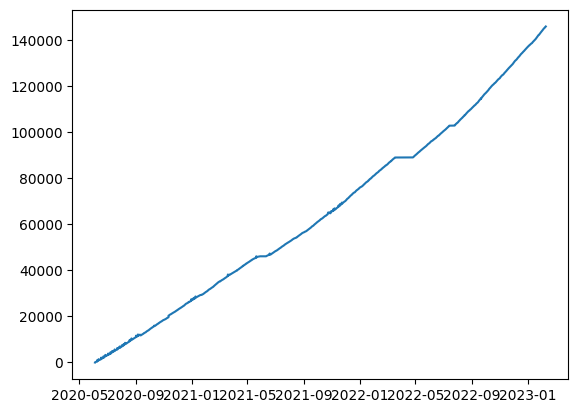

In [8]:
plt.plot(electr_df['timestamp'], electr_df['Total kwH Consumed'])

In [16]:
ts = traces.TimeSeries(list(electr_df[['timestamp', 'Total kwH Consumed']].itertuples(index=False, name=None)))
a = traces.TimeSeries(ts.sample(
    sampling_period=pd.Timedelta(days = 7),
    interpolate='linear'
))


In [21]:
a.keys()

AttributeError: ignored

In [10]:
#electr_df['dy'] = electr_df['Total kwH Consumed']
new_df = pd.DataFrame()
new_df['diff_timestamp'] = 
electr_df.set_index('timestamp')['Total kwH Consumed'].rolling('7D', center = True).mean()

#electr_df['dy'] = np.gradient(electr_df['Total kwH Consumed'], (electr_df['timestamp'] - electr_df['timestamp'].iloc[0]).total_seconds())
#electr_df.plot('timestamp', 'dy')
#print(np.max(dy))

SyntaxError: ignored

In [ ]:
X = electr_df['timestamp']
X = sm.add_constant(X) #Adds constant term
cz_df['w2_or_sc_nz_30_q1_diff'] = cz_df['w2_or_sc_nz_30_q1_m'] - cz_df['w2_or_sc_nz_30_q1_f']
Y_bottom_income_quintile = cz_df['w2_or_sc_nz_30_q1_diff'] #Gender gap is outcome variable
model = sm.OLS(Y_bottom_income_quintile, X, missing = 'drop').fit() 
model.summary()